In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
plt.style.use('ggplot')

In [95]:
df = pd.read_csv("QRM-2022-cw1-data-a.csv")

In [9]:
#First remove NA values from the data
df=df.dropna()
# Calculate daily simple returns
df['simplereturn']=df['SX5E'].pct_change()
#log returns
df['logreturn']=np.log(1+df['simplereturn'])

#Convert to percentage values
df['simplereturn']=df['simplereturn']*100
df['logreturn']=df['logreturn']*100

The mean is : 0.015243112278370824
The standard deviation is: 1.2436489797057162
The skewness is: -0.7764718773797141
The kurtosis is: 10.08311719158637


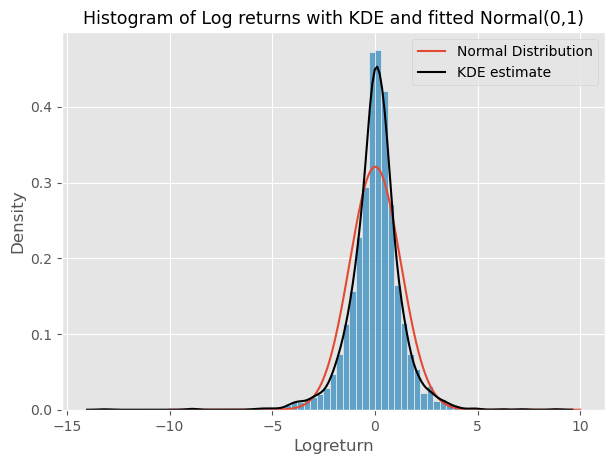

In [10]:
mu=np.mean(df['logreturn'].dropna())
sigma=np.std(df['logreturn'].dropna())
print("The mean is : %s"%mu)
print("The standard deviation is: %s" %sigma)
print("The skewness is: %s" %stat.skew(df['logreturn'].dropna()))
print("The kurtosis is: %s" %stat.kurtosis(df['logreturn'].dropna()))

#Draw the histogram with the kde
plt.figure(figsize=(7,5),dpi=100)
plt.title("Histogram of Log returns with KDE and fitted Normal(0,1)",size=12.5)
n=len(df['logreturn'])
sns_hist=sns.histplot(df['logreturn'],bins=int(70),stat="density")

#now fit the normal distribution with sample mean and standard deviation 
plt.xlabel("Logreturn",size=12)
plt.ylabel("Density",size=12)
x=np.linspace(-10,10,5000)
sns_hist.plot(x,stat.norm.pdf(x,mu,sigma),label="Normal Distribution")
sns.kdeplot(df['logreturn'],color="black",label="KDE estimate")
plt.legend()
plt.show()

# (ii)

In [11]:
#Plot the empirical ACF
import statsmodels.api as sm

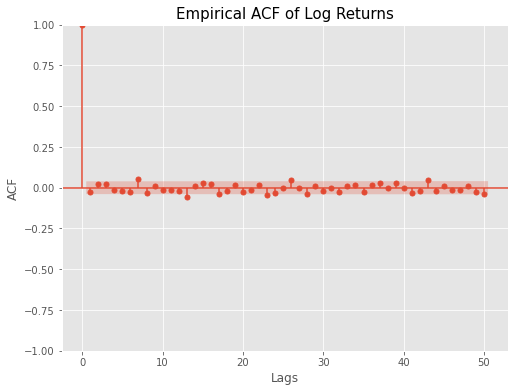

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(df['logreturn'].dropna(),lags=50,title="Empricial ACF of log returns",ax=ax)
plt.title("Empirical ACF of Log Returns",size=15)
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.show()

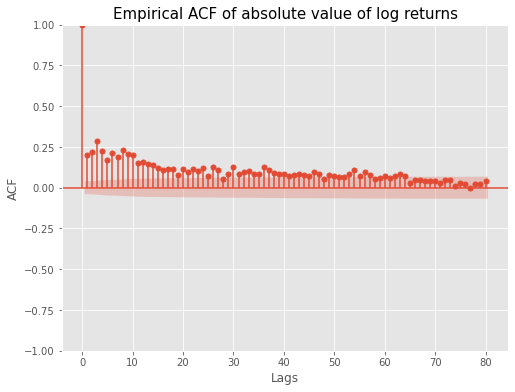

In [13]:
#now consider the absolute value of the log returns
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(np.abs(df['logreturn'].dropna()),lags=80,title="Empirical ACF of absolute value of log returns",ax=ax)
plt.title("Empirical ACF of absolute value of log returns",size=15)
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.show()

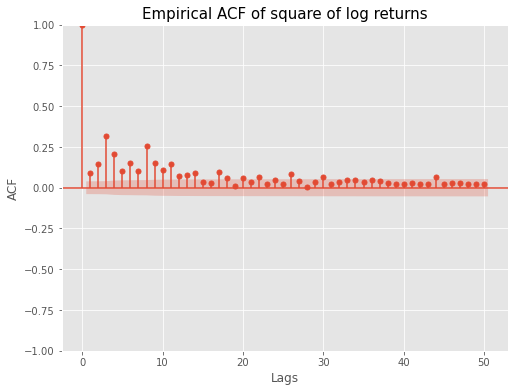

In [14]:
#Finally consider the square of the log returns
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(np.square(df['logreturn'].dropna()),lags=50,title="Empirical ACF of square of log returns",ax=ax)
plt.title("Empirical ACF of square of log returns",size=15)
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.show()

What can we conclude?
###Log Returns
From the initial ACF plot we observe that the time series of the log returns resembles a white noise process. At every lag greater than $0$ the correlation is close to $0$, suggesting the log returns are serially uncorrelated. 
###Absolute Value of log returns
When we observe the ACF of the absolute value of log returns it appears to be the case the fact that there is a positive serial correlation between them. This is due to that we know only focus on the magnitude of the change rather than the direction. Financial data typically displays volaility clustering, implying large movements in asset price will likely be followed by large movements the following day, similarly small movements precede small movements.

Furthermore the ACF decays somewhat slowly, this is because large movements in market indexes can have long lasting effects on the market, this is known as persistence.

###Squared log returns
Again we observe more serial correlations, due to considering the only the magnitude rather than direction of the index movements. However since we square the values this time we give more emphasis to extremely large movements in the index. The ACF decays more quickly here as moderately large movements will be less correlated with extremely large movements after squaring the returns.

#(iii) Use both constrained and unconstrained numerical optimiser by minimizing -1 * log-likelihood
First we look at the unconstrained method.

In [15]:
from scipy.optimize import minimize

In [16]:
def garch11_normal_loglikelihood(mu, alpha0, alpha1, beta1, x):

    var = np.zeros_like(x)

    # We need a proxy for sigma_0^2. Let's take it as the sample variance of the data X
    var[0] = np.var(x, ddof=1)

    # Get all the conditional variance values sigma_t from the GARCH dynamics
    for i in range(1, len(x)):
        var[i] = alpha0 + alpha1 * (x[i-1] - mu)**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) - 0.5 * (x[1:] - mu)**2 / var[1:] - 0.5*np.log(2*np.pi) ) 

In [17]:
x = df['logreturn'].dropna()
x.reset_index(drop=True, inplace=True)

In [18]:
objfun = lambda theta : -1 * garch11_normal_loglikelihood(theta[0], theta[1]**2, theta[2]**2/(1 + theta[2]**2 + theta[3]**2), theta[3]**2/(1 + theta[2]**2 + theta[3]**2), x)
ini_theta = [np.mean(x), 1, 1, 1] # Need to supply an initial guess
print("Initial objective function value: " + str(objfun(ini_theta)))

sol = minimize(objfun, ini_theta, method='nelder-mead', options={'xtol': 1e-8, 'disp': True}) # Call the minimiser

# Convert the optimiser in theta back to the original coordinates (alpha0, alpha1, beta1)
mu = sol.x[0]
alpha0 = sol.x[1]**2
alpha1 = sol.x[2]**2/(1 + sol.x[2]**2 + sol.x[3]**2)
beta1 = sol.x[3]**2/(1 + sol.x[2]**2 + sol.x[3]**2)

print("Estimate of constant mean: " + str(mu))
print("Estimate of alpha0: " + str(alpha0))
print("Estimate of alpha1: " + str(alpha1))
print("Estimate of beta1: " + str(beta1))

Initial objective function value: 4005.874717551864
Optimization terminated successfully.
         Current function value: 3752.044805
         Iterations: 260
         Function evaluations: 470
Estimate of constant mean: 0.05915474291040261
Estimate of alpha0: 0.05501238264696962
Estimate of alpha1: 0.1320137056853363
Estimate of beta1: 0.8343633102512162


In [19]:
objfun2 = lambda y : -1 * garch11_normal_loglikelihood(y[0], y[1], y[2], y[3], x) #set up the objective function f=f(y) parameterised by y=[alpha0,alpha1,beta1]
constraint = lambda y :  1 - y[1] - y[2] # the inequality constriant function c(y):= 1 -y[1] - y[2]= 1- alpha1 - beta1

y0 = [np.mean(x), 1, 0.1, 0.1]  # some initial guess
print("Initial objective function value: " + str(objfun2(y0)))

bnds = ((-np.inf, np.inf), (0,np.inf), (0,1), (0,1)) # individual bound on each parameter

con = {'type': 'ineq', 'fun': constraint} # set up the constraint object

sol = minimize(objfun2,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True}) # Call the minimiser

print("Estimate of constant mean: " + str(sol.x[0]))
print("Estimate of alpha0: " + str(sol.x[1]))
print("Estimate of alpha1: " + str(sol.x[2]))
print("Estimate of beta1: " + str(sol.x[3]))

Initial objective function value: 4030.944503089779
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3752.0448054086646
            Iterations: 25
            Function evaluations: 146
            Gradient evaluations: 25
Estimate of constant mean: 0.05915287430031189
Estimate of alpha0: 0.055012162520124856
Estimate of alpha1: 0.13201411809427058
Estimate of beta1: 0.8343633274177574


In [20]:
# fitted volatilities
var = np.zeros_like(x)
var[0] = np.var(x, ddof=1)
for i in range(1, len(x)):
    var[i] = sol.x[1] + sol.x[2] * (x[i-1] - sol.x[0])**2 + sol.x[3] * var[i-1]
volatilities = np.sqrt(var)

([<matplotlib.axis.XTick at 0x1dbc9e40550>,
 [Text(0, 0, '11/5/2012'),
  Text(200, 0, '8/28/2013'),
  Text(400, 0, '6/23/2014'),
  Text(600, 0, '4/14/2015'),
  Text(800, 0, '1/28/2016'),
  Text(1000, 0, '11/10/2016'),
  Text(1200, 0, '8/29/2017'),
  Text(1400, 0, '6/18/2018'),
  Text(1600, 0, '4/3/2019'),
  Text(1800, 0, '1/24/2020'),
  Text(2000, 0, '11/6/2020'),
  Text(2200, 0, '8/25/2021'),
  Text(2400, 0, '6/9/2022')])

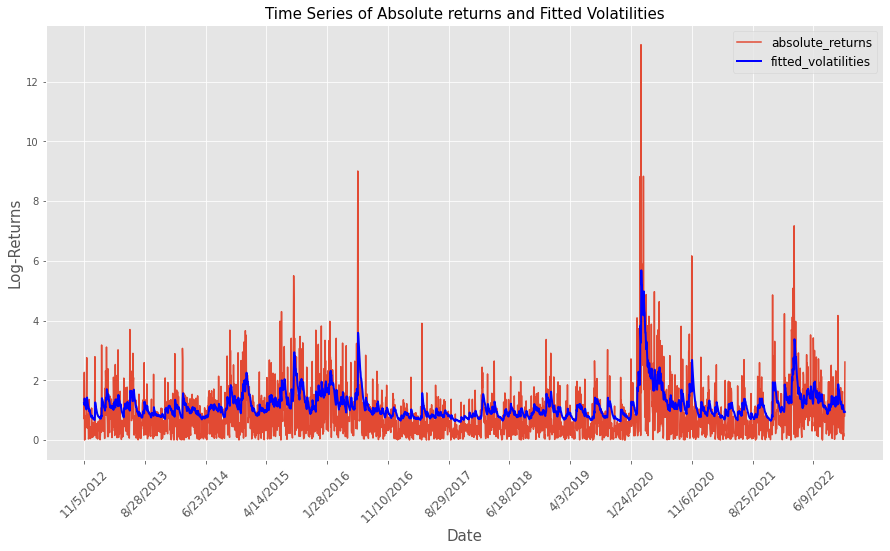

In [21]:
plt.figure(figsize=(15,8))
df_to_plot = pd.DataFrame({"absolute_returns": np.abs(x), "fitted_volatilities": volatilities})
sns.lineplot(data=df_to_plot['absolute_returns'])
sns.lineplot(data=df_to_plot['fitted_volatilities'],linewidth=2,color="blue")
plt.xlabel("Date",size=15)
plt.ylabel("Log-Returns",size=15)
plt.title("Time Series of Absolute returns and Fitted Volatilities",size=15)
plt.legend(labels = ["absolute_returns", "fitted_volatilities"],prop={'size': 12})
plt.xticks(range(0,len(df_to_plot),200),labels=df['Date'][0::200],size=12,rotation=45)

# (iv)
goodness of fit...

Standardized residual mean: -0.05140899893196658
Standardized residual std: 0.9987473852258031


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

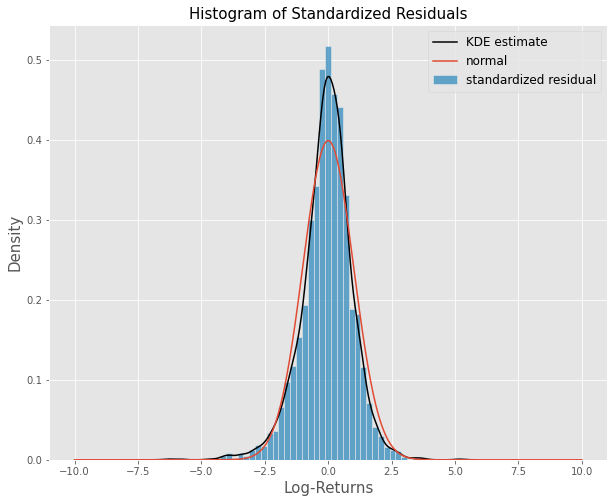

In [22]:
standardized_residuals = (x - sol.x[0])/volatilities
print("Standardized residual mean: " + str(np.mean(standardized_residuals)))
print("Standardized residual std: " + str(np.std(standardized_residuals)))
normal_x = np.linspace(-10,10,len(x))
plt.figure(figsize=(10,8))
sns_ax = sns.histplot(data=standardized_residuals, bins=50, stat="density", label="standardized residual")
plt.title("Histogram of Standardized Residuals",size=15)
sns.kdeplot(standardized_residuals,color="black",label="KDE estimate")
sns_ax.plot(normal_x,stat.norm.pdf(normal_x,0,1),label="normal")
plt.legend(prop={'size': 12})
plt.ylabel("Density",size=15)
plt.xlabel("Log-Returns",size=15)
plt.xticks(size=10)
plt.yticks(size=10)

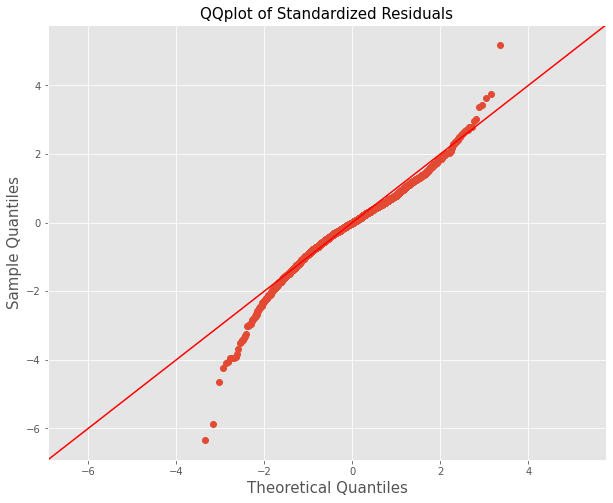

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sm.qqplot(standardized_residuals, line='45',ax=ax) 
plt.title("QQplot of Standardized Residuals",size=15)
plt.xlabel("Theoretical Quantiles",size=15)
plt.ylabel("Sample Quantiles",size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

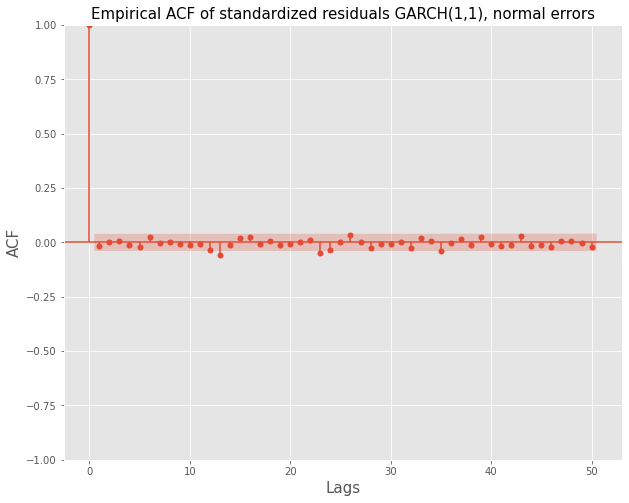

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sm.graphics.tsa.plot_acf(standardized_residuals,lags=50,title="Empirical ACF of standardized residuals GARCH(1,1), normal errors",ax=ax)
plt.title("Empirical ACF of standardized residuals GARCH(1,1), normal errors",size=15)
plt.ylabel("ACF",size=15)
plt.xlabel("Lags",size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()


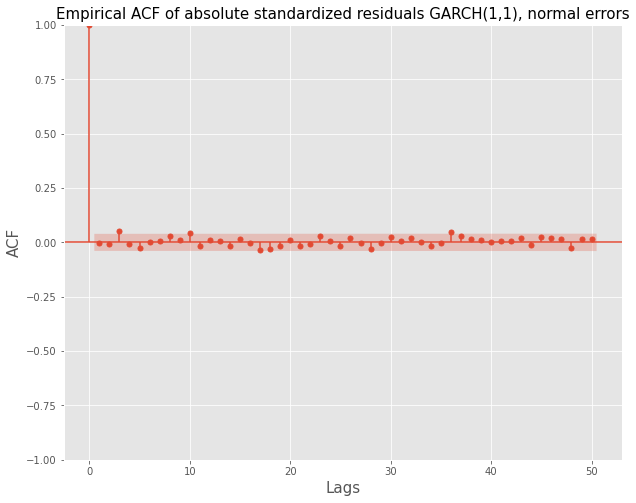

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sm.graphics.tsa.plot_acf(np.abs(standardized_residuals),lags=50,title="Empirical ACF of absolute standardized residuals GARCH(1,1), normal errors",ax=ax)
plt.ylabel("ACF",size=15)
plt.xlabel("Lags",size=15)
plt.title("Empirical ACF of absolute standardized residuals GARCH(1,1), normal errors",size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

# (v)

In [26]:
from scipy.stats import t

In [27]:
def arma11_garch11_t(alpha0,alpha1,beta1,arma_mu,phi1,theta1,nu,x):
    var=np.zeros_like(x) #vector of sigma for garch
    mu=np.zeros_like(x) # vector of mu for arma
    
    #approximate initial value of simga, mu
    var[0]=np.var(x,ddof=1)
    mu[0]=np.mean(x)
    
    #Apply the iterative formula for ARMA(1,1)-Garch(11)
    for i in range(1,len(x)):
        mu[i]=arma_mu+phi1*(x[i-1]-arma_mu)+theta1*(x[i-1]-mu[i-1])
        var[i]=alpha0+alpha1*(x[i-1]-mu[i-1])**2+beta1*var[i-1]
        
    return np.sum(-0.5*np.log(var[1:])+np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]),nu,0,np.sqrt((nu-2)/nu))))

In [28]:
#Model parameter estimation
objfun_armagarch_t=lambda y: -1*arma11_garch11_t(y[0],y[1],y[2],y[3],y[4],y[5],y[6],x)
constraint = lambda y: 1-y[1]-y[2]

y0=[1,0.1,0.1,0,0,0,10]
print("Initial objective function value: "+str(objfun_armagarch_t(y0)))

bnds=((0,np.inf),(0,1),(0,1),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(2.01,np.inf))

con={'type': 'ineq', 'fun': constraint}

sol=minimize(objfun_armagarch_t,y0,method='SLSQP',bounds=bnds,constraints=con,options={'disp':True})

print("Estimate of alpha0: "+str(sol.x[0]))
print("Estimate of alpha1: "+str(sol.x[1]))
print("Estimate of beta1: "+str(sol.x[2]))
print("Estimate of mu: "+str(sol.x[3]))
print("Estimate of phi1: "+str(sol.x[4]))
print("Estimate of theta1: "+str(sol.x[5]))
print("Estimate of nu: "+str(sol.x[6]))

Initial objective function value: 3845.153524884667


C:\Users\PABLO\AppData\Local\Temp\ipykernel_13596\3618613891.py:12: RuntimeWarning: overflow encountered in double_scalars
  var[i]=alpha0+alpha1*(x[i-1]-mu[i-1])**2+beta1*var[i-1]
C:\Users\PABLO\AppData\Local\Temp\ipykernel_13596\3618613891.py:12: RuntimeWarning: invalid value encountered in double_scalars
  var[i]=alpha0+alpha1*(x[i-1]-mu[i-1])**2+beta1*var[i-1]
C:\Users\PABLO\AppData\Local\Temp\ipykernel_13596\3618613891.py:11: RuntimeWarning: overflow encountered in double_scalars
  mu[i]=arma_mu+phi1*(x[i-1]-arma_mu)+theta1*(x[i-1]-mu[i-1])
C:\Users\PABLO\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6315: RuntimeWarning: overflow encountered in square
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
C:\Users\PABLO\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
C:\Users\PABLO\AppData\Local\Temp\ipykernel_13596\3618613891.py:14: RuntimeWarning: divide by

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3647.428436657721
            Iterations: 34
            Function evaluations: 301
            Gradient evaluations: 33
Estimate of alpha0: 0.042150767384500167
Estimate of alpha1: 0.14149684620198755
Estimate of beta1: 0.8426106328011875
Estimate of mu: 0.07403687590384421
Estimate of phi1: 0.9300330586198726
Estimate of theta1: -0.9526148456018014
Estimate of nu: 4.802576196045781


Assessing the model fit:

In [29]:
#first calculate the fitted values
fitted_mu=np.zeros_like(x)
fitted_mu[0]=np.mean(x)
fitted_var=np.zeros_like(x)
fitted_var[0]=np.var(x,ddof=1)
for i in range(1,len(x)):
    fitted_mu[i]=sol.x[3]+sol.x[4]*(x[i-1]-sol.x[3])+sol.x[5]*(x[i-1]-fitted_mu[i-1])
    fitted_var[i]=sol.x[0]+sol.x[1]*(x[i-1]-fitted_mu[i-1])**2+sol.x[2]*fitted_var[i-1]

In [30]:
volatilities=np.sqrt(fitted_var)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

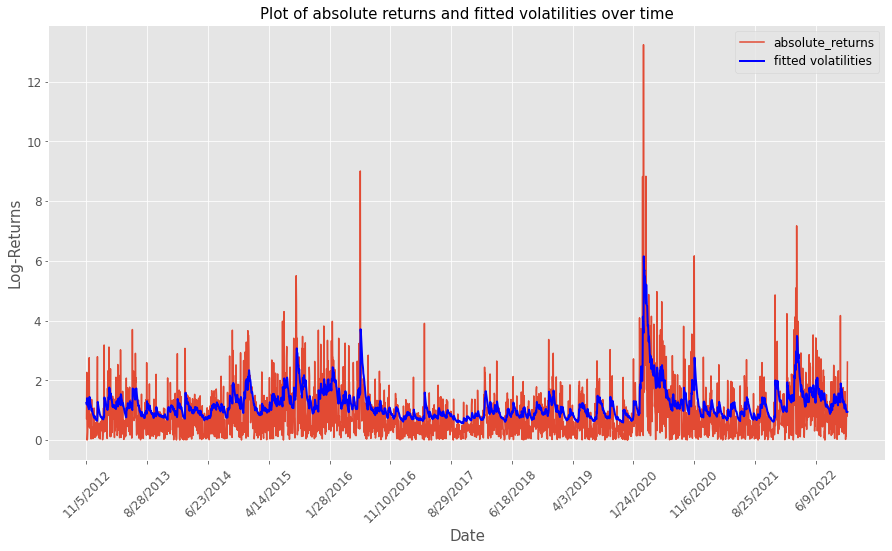

In [31]:
plt.figure(figsize=(15,8))
var_to_plot=pd.DataFrame({"absolute_returns": np.abs(x),"fitted_volatilities": volatilities})
sns.lineplot(data=var_to_plot["absolute_returns"])
sns.lineplot(data=var_to_plot["fitted_volatilities"],color="blue",linewidth=2)
plt.title("Plot of absolute returns and fitted volatilities over time",size=15)
plt.xlabel("Date",size=15)
plt.ylabel("Log-Returns",size=15)
plt.legend(labels=["absolute_returns","fitted volatilities"],prop={'size': 12})
plt.xticks(range(0,len(df_to_plot),200),labels=df['Date'][0::200],size=12,rotation=45)
plt.yticks(size=12)

(array([-15., -10.,  -5.,   0.,   5.,  10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

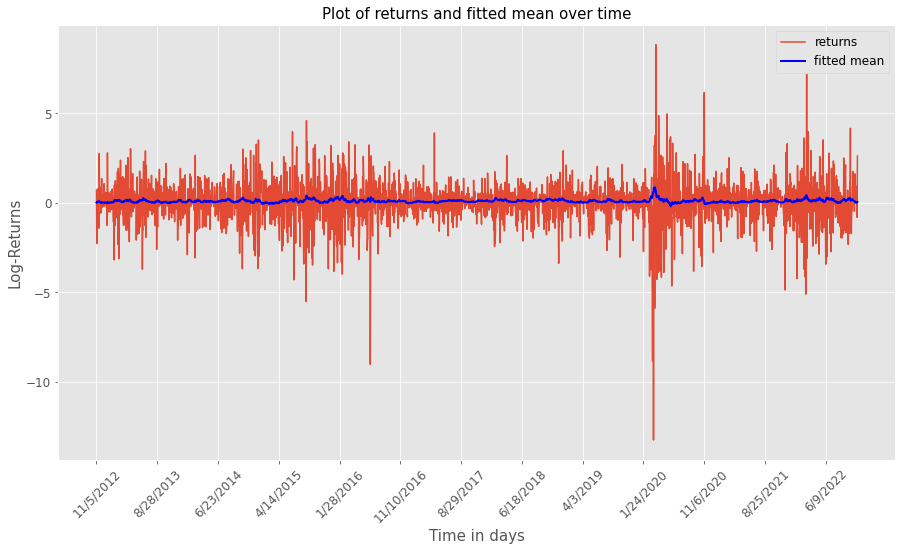

In [32]:
plt.figure(figsize=(15,8))
mu_to_plot=pd.DataFrame({"log_returns":x,"fitted mean":fitted_mu})
sns.lineplot(data=mu_to_plot["log_returns"])
sns.lineplot(data=mu_to_plot["fitted mean"],color="blue",linewidth=2)
plt.title("Plot of returns and fitted mean over time",size=15)
plt.xlabel("Time in days",size=15)
plt.ylabel("Log-Returns",size=15)
plt.legend(labels=["returns","fitted mean"],prop={'size': 12})
plt.xticks(range(0,len(df_to_plot),200),labels=df['Date'][0::200],size=12,rotation=45)
plt.yticks(size=12)

Standardized residual mean: -0.0814033601183903
Standardized residual std: 0.9866804633839011
(4.920641573043564, -0.03363186207133452, 0.767604994984654)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

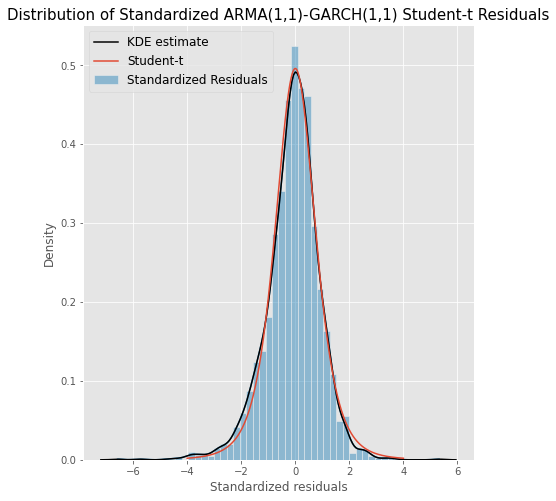

In [33]:
plt.figure(figsize=(7,8))
standardized_residualsAG=(x-fitted_mu)/volatilities
print("Standardized residual mean: "+str(np.mean(standardized_residualsAG)))
print("Standardized residual std: "+str(np.std(standardized_residualsAG)))
nu=sol.x[6]
scale=np.sqrt((nu-2)/nu)
t_x=np.linspace(-4,4,len(x))
sns_ax=sns.histplot(data=standardized_residualsAG,bins=50,stat="density",kde=True,label="Standardized Residuals")
sns.kdeplot(standardized_residualsAG,color="black",label="KDE estimate")
print(stat.t.fit(standardized_residualsAG))
sns_ax.plot(t_x,stat.t.pdf(t_x,df=nu,scale=scale),label="Student-t")
plt.xlabel("Standardized residuals",size=12)
plt.ylabel("Density",size=12)
plt.title("Distribution of Standardized ARMA(1,1)-GARCH(1,1) Student-t Residuals",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=10)
plt.yticks(size=10)


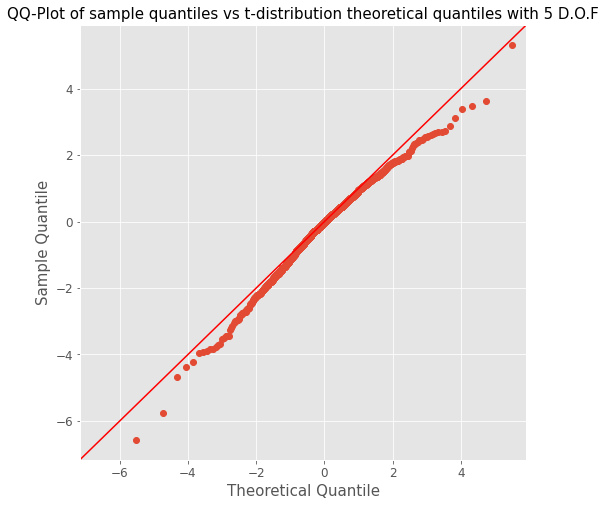

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sm.qqplot(standardized_residualsAG,dist=stat.t,distargs=([5]),scale=scale,line='45',ax=ax)
plt.title("QQ-Plot of sample quantiles vs t-distribution theoretical quantiles with 5 D.O.F",size=15)
plt.ylabel("Sample Quantile",size=15)
plt.xlabel("Theoretical Quantile", size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

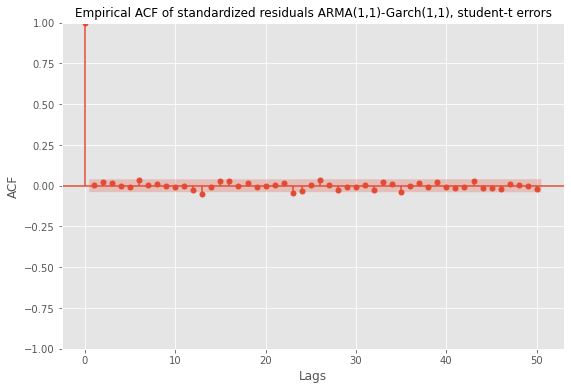

In [35]:
fig, ax = plt.subplots(figsize=(9, 6))
sm.graphics.tsa.plot_acf(standardized_residualsAG,lags=50,title="Empirical ACF of standardized residuals ARMA(1,1)-Garch(1,1), student t errors",ax=ax)

plt.ylabel("ACF",size=12)
plt.title("Empirical ACF of standardized residuals ARMA(1,1)-Garch(1,1), student-t errors",size=12)
plt.ylabel("ACF",size=12)
plt.xlabel("Lags",size=12)
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()

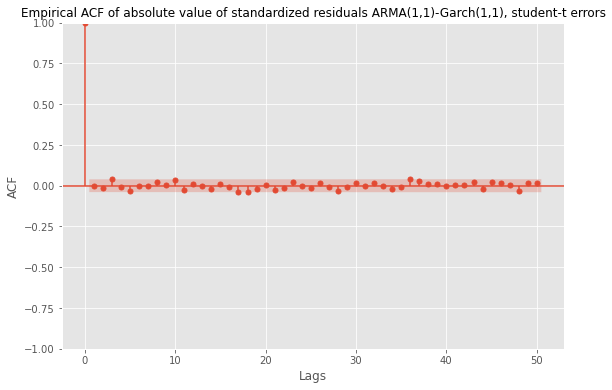

In [36]:
fig, ax = plt.subplots(figsize=(9, 6))
sm.graphics.tsa.plot_acf(np.abs(standardized_residualsAG),lags=50,title="Empirical ACF of standardized residuals ARMA(1,1)-Garch(1,1), student t errors",ax=ax)
plt.ylabel("ACF",size=12)
plt.title("Empirical ACF of absolute value of standardized residuals ARMA(1,1)-Garch(1,1), student-t errors",size=12)
plt.ylabel("ACF",size=12)
plt.xlabel("Lags",size=12)
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()

Since we have not previously observed a GARCH(1,1) model with student-t errors we should plot this in order to conduct a thorough analysis of the appropriateness of including an ARMA(1,1) component.

In [37]:
#Plotting with GARCH(1,1) with student-t
def garch11_t_loglikelihood(mu, alpha0, alpha1, beta1, nu, x):

    var = np.zeros_like(x)

    # We need a proxy for sigma_0^2. Let's take it as the sample variance of the data X
    var[0] = np.var(x, ddof=1)

    # Get all the conditional variance values from the GARCH dynamics
    for i in range(1, len(x)):
        var[i] = alpha0 + alpha1 * (x[i-1]-mu)**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu)/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))

In [38]:
objfun_t = lambda y : -1 * garch11_t_loglikelihood(y[0], y[1], y[2], y[3], y[4], x)
constraint = lambda y :  1 - y[1] - y[2]

y0 = [np.mean(x),1, 0.1, 0.1, 10]
print("Initial objective function value: " + str(objfun_t(y0)))

bnds = ((-np.inf,np.inf), (0,np.inf), (0,1), (0,1), (2.01, np.inf))

con = {'type': 'ineq', 'fun': constraint} 

sol = minimize(objfun_t,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True})

print("Estimate of alpha0: " + str(sol.x[1]))
print("Estimate of alpha1: " + str(sol.x[2]))
print("Estimate of beta1: " + str(sol.x[3]))
print("Estimate of nu: " + str(sol.x[4]))
print("Estimate of mu: "+str(sol.x[0]))

Initial objective function value: 3843.7102153140713
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3652.4132032016505
            Iterations: 25
            Function evaluations: 172
            Gradient evaluations: 25
Estimate of alpha0: 0.041843691563705425
Estimate of alpha1: 0.14188283890575565
Estimate of beta1: 0.8423995225639493
Estimate of nu: 4.858934916222256
Estimate of mu: 0.07649685634040233


Standardized residual mean: -0.0814033601183903
Standardized residual std: 0.9866804633839011


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

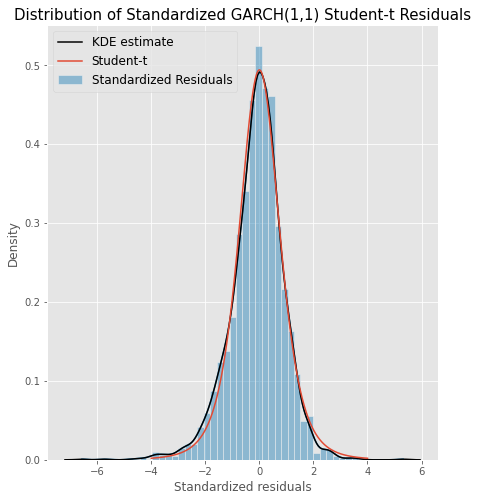

In [39]:
plt.figure(figsize=(7,8))
standardized_residualsT=(x-fitted_mu)/volatilities
print("Standardized residual mean: "+str(np.mean(standardized_residualsT)))
print("Standardized residual std: "+str(np.std(standardized_residualsT)))
nu=sol.x[4]
scale=np.sqrt((nu-2)/nu)
t_x=np.linspace(-4,4,len(x))
sns_ax=sns.histplot(data=standardized_residualsT,bins=50,stat="density",kde=True,label="Standardized Residuals")
sns.kdeplot(standardized_residualsT,color="black",label="KDE estimate")
sns_ax.plot(t_x,stat.t.pdf(t_x,df=nu,scale=scale),label="Student-t")
plt.xlabel("Standardized residuals",size=12)
plt.ylabel("Density",size=12)
plt.title("Distribution of Standardized GARCH(1,1) Student-t Residuals",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=10)
plt.yticks(size=10)

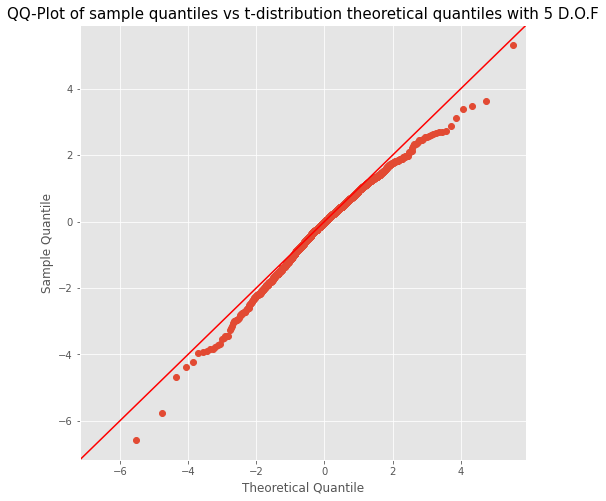

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
sm.qqplot(standardized_residualsT,dist=stat.t,distargs=([5]),scale=scale,line='45',ax=ax)
plt.title("QQ-Plot of sample quantiles vs t-distribution theoretical quantiles with 5 D.O.F",size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel("Theoretical Quantile",size=12)
plt.ylabel("Sample Quantile",size=12)
plt.show()

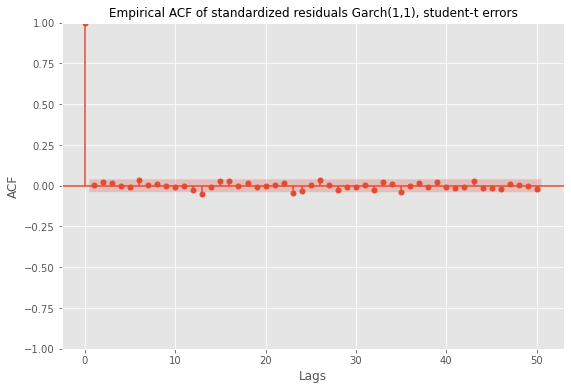

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
sm.graphics.tsa.plot_acf(standardized_residualsT,lags=50,title="Empirical ACF of standardized residuals Garch(1,1), student t errors",ax=ax)
plt.ylabel("ACF",size=12)
plt.title("Empirical ACF of standardized residuals Garch(1,1), student-t errors",size=12)
plt.xlabel("Lags",size=12)
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()


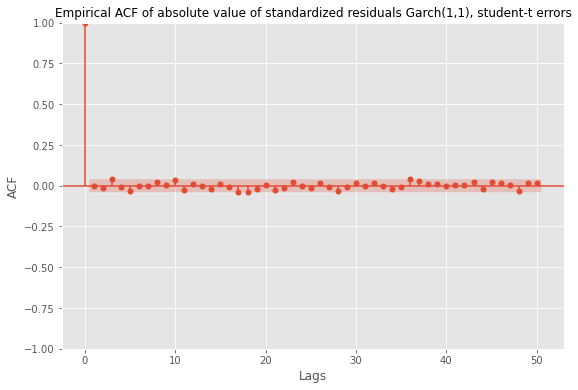

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
sm.graphics.tsa.plot_acf(np.abs(standardized_residualsT),lags=50,title="Empirical ACF of standardized residuals Garch(1,1), student t errors",ax=ax)
plt.title("Empirical ACF of absolute value of standardized residuals Garch(1,1), student-t errors",size=12)
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()

# Q2
# (i)

In [43]:
from scipy.stats import chi2
from scipy.stats import norm
import math

In [97]:
dog=pd.read_csv("QRM-2022-cw1-data-b.csv")
dog.head(5)

,Date,DOG
0,11/5/2012,135.529114
1,11/6/2012,134.319016
2,11/7/2012,137.090485
3,11/8/2012,138.495743
4,11/9/2012,138.534821


In [45]:
#compute log returns
dog['simplereturn']=dog['DOG'].pct_change()
#log returns
dog['logreturn']=np.log(1+dog['simplereturn'])

#Convert to percentage values
dog['simplereturn']=dog['simplereturn']*100
dog['logreturn']=dog['logreturn']*100
dog['linloss']=dog['logreturn']*(-1)
dog.head(10)

,Date,DOG,simplereturn,logreturn,linloss
0,11/5/2012,135.529114,NaN,NaN,NaN
1,11/6/2012,134.319016,-0.892869,-0.896879,0.896879
2,11/7/2012,137.090485,2.063348,2.042350,-2.042350
3,11/8/2012,138.495743,1.025059,1.019841,-1.019841
4,11/9/2012,138.534821,0.028216,0.028212,-0.028212
5,11/12/2012,138.417679,-0.084558,-0.084594,0.084594
6,11/13/2012,139.042236,0.451212,0.450197,-0.450197
7,11/14/2012,140.915909,1.347557,1.338558,-1.338558
8,11/15/2012,141.150131,0.166214,0.166076,-0.166076
9,11/16/2012,140.798767,-0.248929,-0.249240,0.249240


In [46]:
df = dog.copy()
df["Var_HS_95"] = dog['linloss'].rolling(window=500).quantile(0.95)
df["Var_HS_99"] = dog['linloss'].rolling(window=500).quantile(0.99)
df

,Date,DOG,simplereturn,logreturn,linloss,Var_HS_95,Var_HS_99
0,11/5/2012,135.529114,NaN,NaN,NaN,NaN,NaN
1,11/6/2012,134.319016,-0.892869,-0.896879,0.896879,NaN,NaN
2,11/7/2012,137.090485,2.063348,2.042350,-2.042350,NaN,NaN
3,11/8/2012,138.495743,1.025059,1.019841,-1.019841,NaN,NaN
4,11/9/2012,138.534821,0.028216,0.028212,-0.028212,NaN,NaN
...,...,...,...,...,...,...,...
2514,10/31/2022,33.790001,0.326606,0.326074,-0.326074,1.738253,2.730387
2515,11/1/2022,33.889999,0.295940,0.295503,-0.295503,1.731367,2.730387
2516,11/2/2022,34.430000,1.593393,1.580832,-1.580832,1.731367,2.730387
2517,11/3/2022,34.590000,0.464711,0.463635,-0.463635,1.659236,2.535241


In [47]:
linloss_arr = df['linloss'].to_numpy()
linloss_arr = linloss_arr[~np.isnan(linloss_arr)]
Var_HS_95 = df['Var_HS_95'].to_numpy()
Var_HS_95 = Var_HS_95[~np.isnan(Var_HS_95)][:-1]
Var_HS_99 = df['Var_HS_99'].to_numpy()
Var_HS_99 = Var_HS_99[~np.isnan(Var_HS_99)][:-1]

In [48]:
no_of_violation_95 = np.zeros(len(Var_HS_95))
no_of_violation_99 = np.zeros(len(Var_HS_95))
for i in range(len(Var_HS_95)):
  no_of_violation_95[i] = sum([1 if loss >= Var_HS_95[i] else 0 for loss in linloss_arr[i:i+500]])
  no_of_violation_99[i] = sum([1 if loss >= Var_HS_99[i] else 0 for loss in linloss_arr[i:i+500]])

loss_under_violation_95 = np.zeros(len(Var_HS_95))
loss_under_violation_99 = np.zeros(len(Var_HS_95))
for i in range(len(Var_HS_95)):
  loss_under_violation_95[i] = sum([loss if loss >= Var_HS_95[i] else 0 for loss in linloss_arr[i:i+500]])
  loss_under_violation_99[i] = sum([loss if loss >= Var_HS_99[i] else 0 for loss in linloss_arr[i:i+500]])

ES_HS_95 = np.array(loss_under_violation_95) / np.array(no_of_violation_95)
ES_HS_99 = np.array(loss_under_violation_99) / np.array(no_of_violation_99)


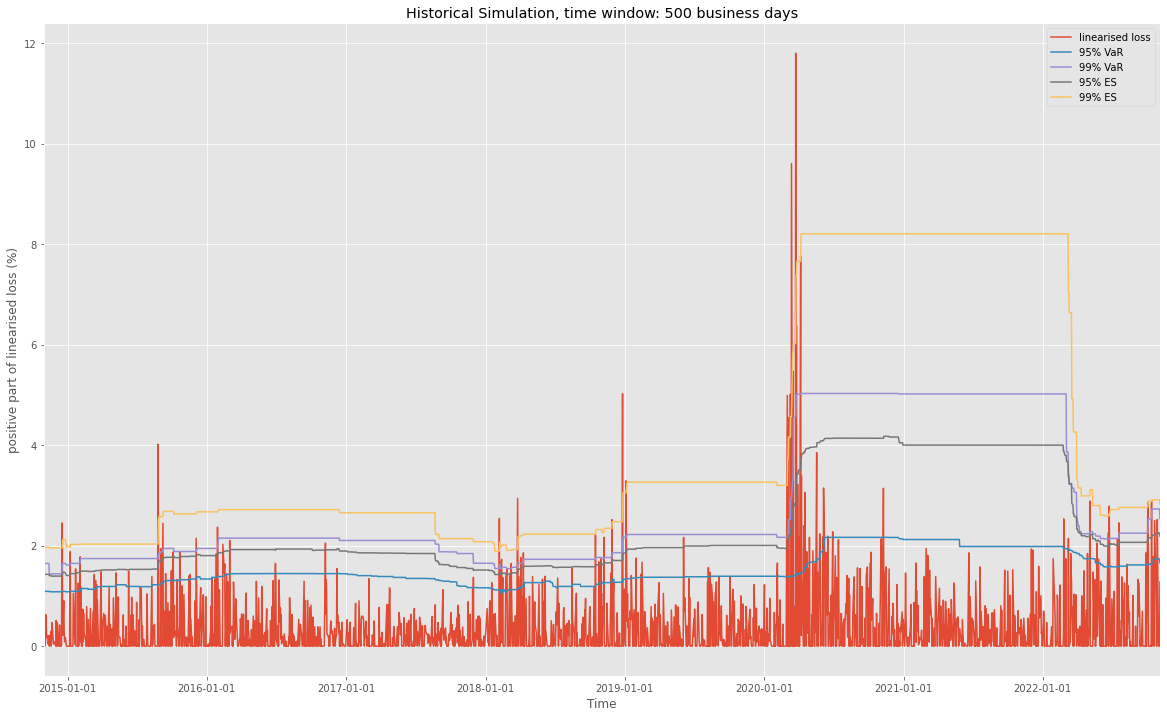

In [49]:
import matplotlib.dates as mdates
n=len(linloss_arr)
y=np.zeros(n)
for i in range(1,n):
  y[i]=linloss_arr[i] if linloss_arr[i]>0 else y[i]

x=dog['Date'].iloc[501:].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in x]
df_to_plot = pd.DataFrame(data = np.array([y[500:], Var_HS_95, Var_HS_99, ES_HS_95, ES_HS_99]).T, 
                  index = index, 
                  columns = ["linearised loss", "95% VaR", "99% VaR", "95% ES", "99% ES"])

ax = df_to_plot.plot(figsize=(20, 12))
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Historical Simulation, time window: 500 business days")
plt.show()

In [50]:
# len(linloss)=2518, len(var) = 2018
def totalNumberOfViolations(linloss, VaR):
  res = 0
  for i in range(len(VaR)-1):
    if linloss[i+500] > VaR[i]:
      res += 1

  return res

In [51]:
total_number_of_violations_95 = totalNumberOfViolations(linloss_arr, Var_HS_95)
total_number_of_violations_99 = totalNumberOfViolations(linloss_arr, Var_HS_99)

# T = 2018 because the last entry of Var_HS is discarded
pi_hat_95 = total_number_of_violations_95/(len(Var_HS_95))
pi_hat_99 = total_number_of_violations_99/(len(Var_HS_99))

print(total_number_of_violations_95)
print(total_number_of_violations_99)
print(pi_hat_95)
print(pi_hat_99)

119
37
0.058969276511397425
0.018334985133795837


Unconditional coverage test

In [52]:
def calculateUCLikelihoodRatio(level, pi_hat, T, number_of_violations):
  theoretical_likelihood = pow(level, T - number_of_violations) * pow(1-level, number_of_violations)
  empirical_likelihood = pow(1 - pi_hat, T - number_of_violations) * pow(pi_hat, number_of_violations)

  return -2 * math.log(theoretical_likelihood/empirical_likelihood)

In [53]:
T = 2018
LR_UC_95 = calculateUCLikelihoodRatio(0.95, pi_hat_95, T, total_number_of_violations_95)
LR_UC_99 = calculateUCLikelihoodRatio(0.99, pi_hat_99, T, total_number_of_violations_99)
print(LR_UC_95)
print(LR_UC_99)

3.2398973282676597
11.36272608291783


In [54]:
df = 1
pval_95 = 1 - chi2.cdf(LR_UC_95, df)
pval_99 = 1 - chi2.cdf(LR_UC_99, df)
print(pval_95)
print(pval_99)

0.07186514168241165
0.0007493276047942921


In [55]:
T_1_95 = totalNumberOfViolations(linloss_arr[1:], Var_HS_95[1:])
T_1_99 = totalNumberOfViolations(linloss_arr[1:], Var_HS_99[1:])
pi_hat_95 = T_1_95/(len(Var_HS_95))
pi_hat_99 = T_1_99/(len(Var_HS_99))
# same as before

In [56]:
# below function calculates T00, T01, T10, T11
def calculateTransitionNumber(linloss, VaR):
  T00 = 0
  T01 = 0
  T10 = 0
  T11 = 0
  I = 1 if linloss[500] > VaR[0] else 0
  for i in range(1, len(VaR)-1):
    if I == 0 and linloss[i+500] <= VaR[i]:
      T00 += 1
    elif I == 0 and linloss[i+500] > VaR[i]:
      T01 += 1
      I = 1
    elif I == 1 and linloss[i+500] <= VaR[i]:
      T10 += 1
      I = 0
    elif I == 1 and linloss[i+500] > VaR[i]:
      T11 += 1
  
  return (T00, T01, T10, T11)

In [57]:
# this is the likelihood in the denominator
def calculateIndepLikelihoodRatio(pi_hat, pi_hat_01, pi_hat_11, transition_numbers_tuple):
  (T00, T01, T10, T11) = transition_numbers_tuple
  likelihood_H0 = pow(1 - pi_hat, T00+T10) * pow(pi_hat, T01+T11)
  likelihood_True = pow(1 - pi_hat_01, T00) * pow(pi_hat_01, T01) * pow(1 - pi_hat_11, T10) * pow(pi_hat_11, T11)

  return -2 * math.log(likelihood_H0/likelihood_True)

In [58]:
# first calculate for 95 level
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, Var_HS_95)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1791 106 106 13
2016
0.0558777016341592
0.1092436974789916


In [59]:
LR_indep_95 = calculateIndepLikelihoodRatio(pi_hat_95, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_95 = LR_UC_95 + LR_indep_95
df = 2
pval_joint_95 = 1 - chi2.cdf(LR_joint_95, df)
print(LR_indep_95)
print(LR_joint_95)
print(pval_joint_95)

4.723071986092233
7.962969314359892
0.01865791815244844


In [60]:
# then calculate for 99 level
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, Var_HS_99)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1946 33 33 4
2016
0.01667508842849924
0.10810810810810811


In [61]:
LR_indep_99 = calculateIndepLikelihoodRatio(pi_hat_99, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_99 = LR_UC_99 + LR_indep_99
df = 2
pval_joint_99 = 1 - chi2.cdf(LR_joint_99, df)
print(LR_indep_99)
print(LR_joint_99)
print(pval_joint_99)

8.177169094059423
19.539895176977254
5.7143346940513595e-05


Backtesting ES

In [62]:
def calculateXis(linloss, VaR, ES):
  xis_arr = np.zeros(len(VaR)-1)

  for i in range(len(VaR)-1):
    if linloss[i+500] > VaR[i]:
      xis_arr[i] = linloss[i+500] - ES[i]

  return xis_arr

In [63]:
xis_arr_95 = calculateXis(linloss_arr, Var_HS_95, ES_HS_95)
z_score_95 = sum(xis_arr_95) / math.sqrt(sum(np.square(xis_arr_95)))
pval_95 = 1 - norm.cdf(z_score_95)
print(z_score_95)
print(pval_95)

1.2808793008439847
0.10011803216221116


In [64]:
xis_arr_99 = calculateXis(linloss_arr, Var_HS_99, ES_HS_99)
z_score_99 = sum(xis_arr_99) / math.sqrt(sum(np.square(xis_arr_99)))
pval_99 = 1 - norm.cdf(z_score_99)
print(z_score_99)
print(pval_99)

1.7355092827509568
0.04132531936696371


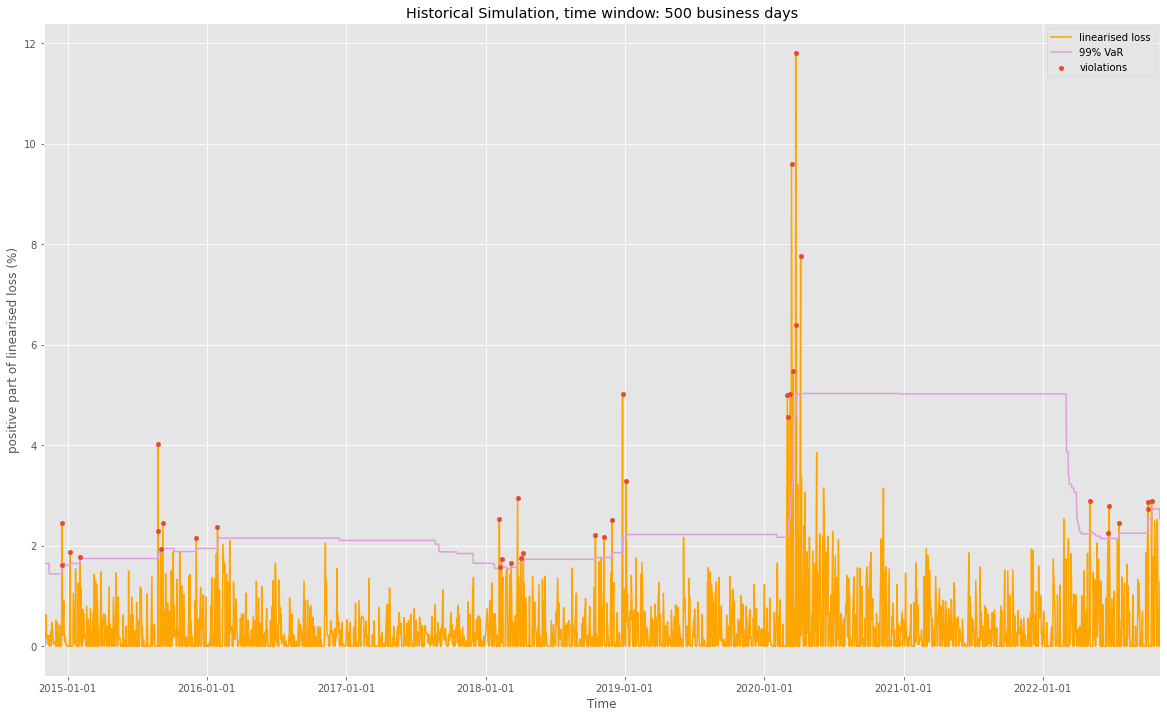

In [65]:
df_to_plot = pd.DataFrame(data = np.array([y[500:], Var_HS_99]).T, 
                  index = index, 
                  columns = ["linearised loss", "99% VaR"])

ax = df_to_plot.plot(figsize=(20, 12), color={"linearised loss": "orange", "99% VaR": "plum"})
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
ax.scatter(df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]].index,
            df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]]["linearised loss"], 
            s=20, zorder=10, label = "violations")
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Historical Simulation, time window: 500 business days")
plt.legend()
plt.show()

(ii) Historical Simulation (EMWA)

In [66]:
alpha=0.06
n=len(linloss_arr)
#vector of sigma^2
var=np.zeros(n)
#initial estimate is the variance of the sample
#var[0]=np.var(linloss_arr)
var[0]=.0
#start EWMA procedure to estimate theta
for i in range(1,n):
    var[i]=alpha*pow(linloss_arr[i-1], 2)+(1-alpha)*var[i-1]

In [67]:
# calculate the standardised residuals under EWMA
# standardised residuals is (X_t - mu_hat_t)/sigma_hat_t, but since mu_hat_t is zero, we just have X_t/sigma_hat_t
z=linloss_arr/np.sqrt(var)
length = len(z)-500+1

#using historical simulation on z find q-alpha(z) and ES(z)
# we can re use part(i) now applied to z
z_q95=np.zeros(length)
z_q99=np.zeros(length)
z_ES95=np.zeros(length)
z_ES99=np.zeros(length)

for i in range(length):
    z_q95[i]=np.quantile(z[i:i+500],0.95)
    z_q99[i]=np.quantile(z[i:i+500],0.99)
    z_ES95[i]= sum([elem if elem >= z_q95[i] else 0 for elem in z[i:i+500]]) / sum([1 if elem >= z_q95[i] else 0 for elem in z[i:i+500]])
    z_ES99[i]= sum([elem if elem >= z_q99[i] else 0 for elem in z[i:i+500]]) / sum([1 if elem >= z_q99[i] else 0 for elem in z[i:i+500]])

# shift down by 1
z_q95 = z_q95[:-1]
z_q99 = z_q99[:-1]
z_ES95 = z_ES95[:-1]
z_ES99 = z_ES99[:-1]

C:\Users\PABLO\AppData\Local\Temp\ipykernel_13596\1943350668.py:3: RuntimeWarning: divide by zero encountered in true_divide
  z=linloss_arr/np.sqrt(var)


In [68]:
#now apply formulae to generate VaR and ES estimates for linearised losses
sigmas=np.sqrt(var)
fhsv95=sigmas[500:]*z_q95
fhsv99=sigmas[500:]*z_q99
fhsES95=sigmas[500:]*z_ES95
fhsES99=sigmas[500:]*z_ES99

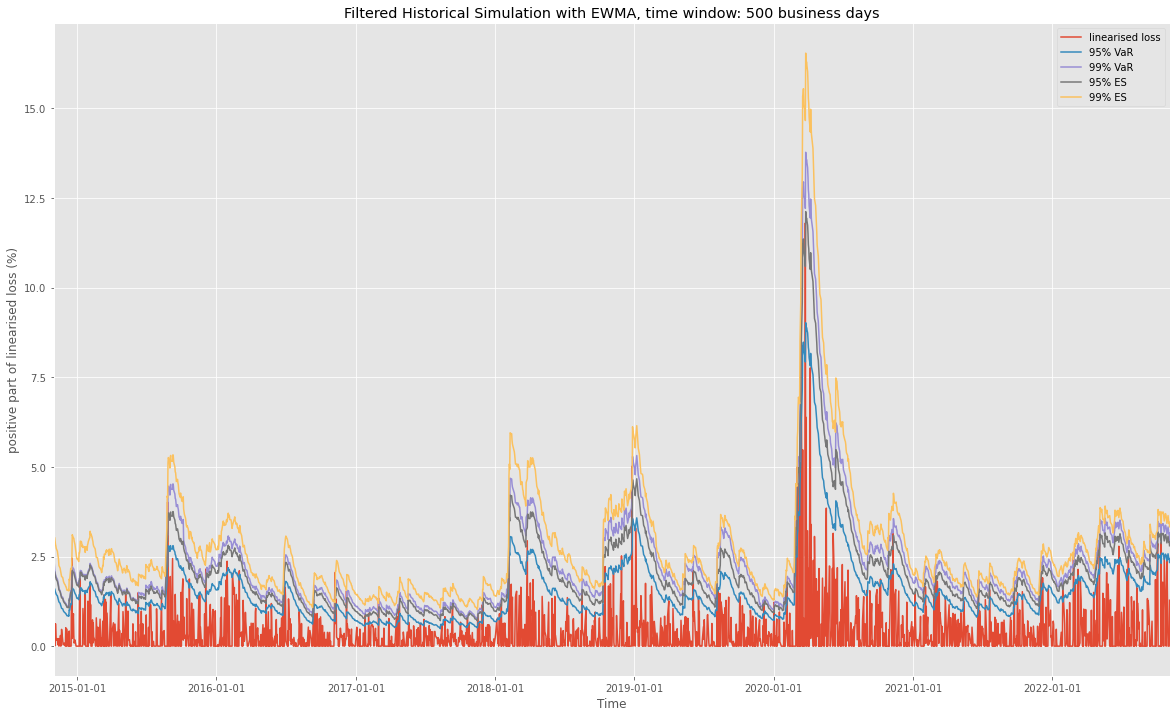

In [69]:
x=dog['Date'].iloc[501:].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in x]
df_to_plot = pd.DataFrame(data = np.array([y[500:], fhsv95, fhsv99, fhsES95, fhsES99]).T, 
                  index = index, 
                  columns = ["linearised loss", "95% VaR", "99% VaR", "95% ES", "99% ES"])

n=len(linloss_arr)
y=np.zeros(n)
for i in range(1,n):
  y[i]=linloss_arr[i] if linloss_arr[i]>0 else y[i]

ax = df_to_plot.plot(figsize=(20, 12))
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Filtered Historical Simulation with EWMA, time window: 500 business days")
plt.show()

In [70]:
total_number_of_violations_95 = totalNumberOfViolations(linloss_arr, fhsv95)
total_number_of_violations_99 = totalNumberOfViolations(linloss_arr, fhsv99)

# T = 2018 because the last entry of Var_HS is discarded
pi_hat_95 = total_number_of_violations_95/(len(fhsv95))
pi_hat_99 = total_number_of_violations_99/(len(fhsv99))

print(total_number_of_violations_95)
print(total_number_of_violations_99)
print(pi_hat_95)
print(pi_hat_99)

102
24
0.05054509415262636
0.011892963330029732


Unconditional Coverage Test

In [71]:
T = 2018
LR_UC_95 = calculateUCLikelihoodRatio(0.95, pi_hat_95, T, total_number_of_violations_95)
LR_UC_99 = calculateUCLikelihoodRatio(0.99, pi_hat_99, T, total_number_of_violations_99)
print(LR_UC_95)
print(LR_UC_99)

0.012580011042316116
0.6886759616615415


In [72]:
df = 1
pval_95 = 1 - chi2.cdf(LR_UC_95, df)
pval_99 = 1 - chi2.cdf(LR_UC_99, df)
print(pval_95)
print(pval_99)

0.9106960302873175
0.4066151006441022


Joint test

Level 95

In [73]:
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, fhsv95)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1817 97 97 5
2016
0.05067920585161965
0.049019607843137254


In [74]:
LR_indep_95 = calculateIndepLikelihoodRatio(pi_hat_95, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_95 = LR_UC_95 + LR_indep_95
df = 2
pval_joint_95 = 1 - chi2.cdf(LR_joint_95, df)
print(LR_indep_95)
print(LR_joint_95)
print(pval_joint_95)

0.00571067750316757
0.018290688545483685
0.990896347197109


Level 99

In [75]:
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, fhsv99)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1969 23 23 1
2016
0.011546184738955823
0.041666666666666664


In [76]:
LR_indep_99 = calculateIndepLikelihoodRatio(pi_hat_99, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_99 = LR_UC_99 + LR_indep_99
df = 2
pval_joint_99 = 1 - chi2.cdf(LR_joint_99, df)
print(LR_indep_99)
print(LR_joint_99)
print(pval_joint_99)

1.1207054697586556
1.809381431420197
0.4046670229032687


Backtesting ES

In [77]:
xis_arr_95 = calculateXis(linloss_arr, fhsv95, fhsES95)
z_score_95 = sum(xis_arr_95) / math.sqrt(sum(np.square(xis_arr_95)))
pval_95 = 1 - norm.cdf(z_score_95)
print(z_score_95)
print(pval_95)

0.1910605255024541
0.42423908697944945


In [78]:
xis_arr_99 = calculateXis(linloss_arr, fhsv99, fhsES99)
z_score_99 = sum(xis_arr_99) / math.sqrt(sum(np.square(xis_arr_99)))
pval_99 = 1 - norm.cdf(z_score_99)
print(z_score_99)
print(pval_99)

-1.3728895691774812
0.9151066601114631


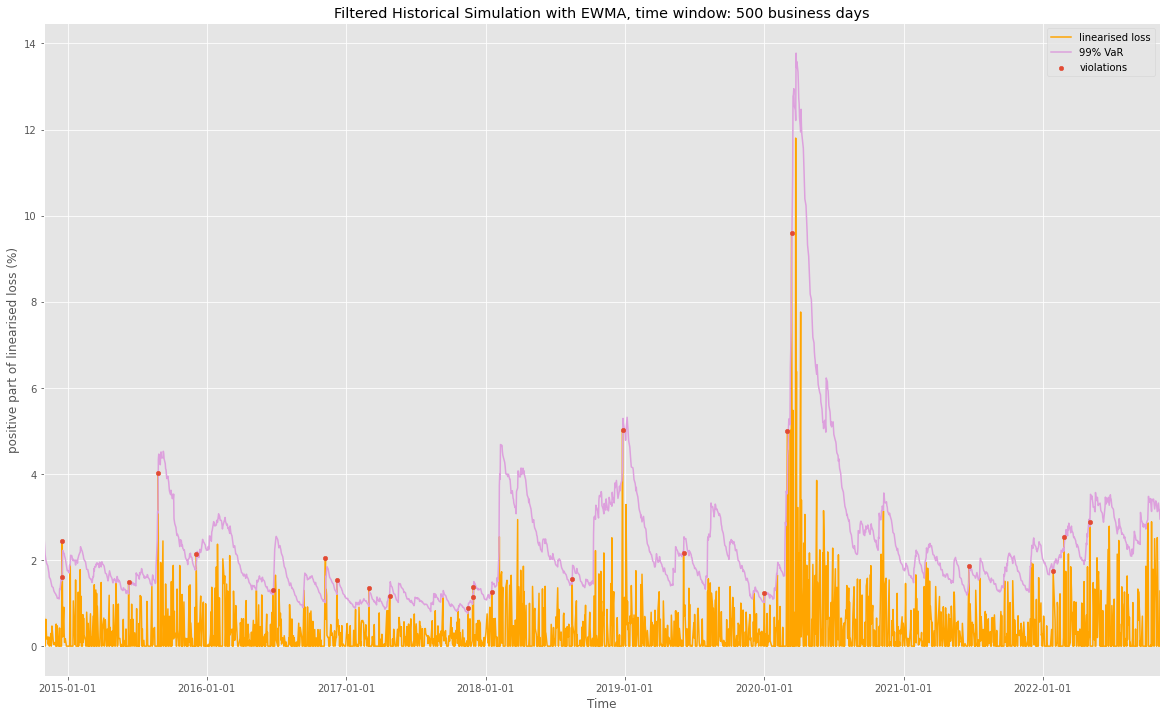

In [79]:
df_to_plot = pd.DataFrame(data = np.array([y[500:], fhsv99]).T, 
                  index = index, 
                  columns = ["linearised loss", "99% VaR"])

ax = df_to_plot.plot(figsize=(20, 12), color={"linearised loss": "orange", "99% VaR": "plum"})
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
ax.scatter(df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]].index,
            df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]]["linearised loss"], 
            s=20, zorder=10, label = "violations")
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Filtered Historical Simulation with EWMA, time window: 500 business days")
plt.legend()
plt.show()

# (iii)

In [80]:
!pip install arch
from arch.univariate import arch_model

In [81]:
garch_var_95 = np.zeros(len(linloss_arr)-500+1) # len = 2019
garch_var_99 = np.zeros(len(linloss_arr)-500+1) # len = 2019
garch_es_95 = np.zeros(len(linloss_arr)-500+1) # len = 2019
garch_es_99 = np.zeros(len(linloss_arr)-500+1) # len = 2019

for i in range(len(linloss_arr)-500+1):
  model = arch_model(linloss_arr[i:i+500], mean='constant', p=1, q=1, dist='normal')
  res = model.fit(update_freq=1,disp=False)
  std_res_95q = np.quantile(res.std_resid,0.95)
  std_res_99q = np.quantile(res.std_resid,0.99)
  sigma_hat = np.sqrt(res.forecast(reindex=False).variance).iloc[0,0]
  mu_hat = res.params.mu
  es_std_res_95q = sum([elem if elem >= std_res_95q else 0 for elem in res.std_resid]) / sum([1 if elem >= std_res_95q else 0 for elem in res.std_resid])
  es_std_res_99q = sum([elem if elem >= std_res_99q else 0 for elem in res.std_resid]) / sum([1 if elem >= std_res_99q else 0 for elem in res.std_resid])
  garch_var_95[i] = mu_hat + sigma_hat * std_res_95q
  garch_var_99[i] = mu_hat + sigma_hat * std_res_99q
  garch_es_95[i] = mu_hat + sigma_hat * es_std_res_95q
  garch_es_99[i] = mu_hat + sigma_hat * es_std_res_99q

In [82]:
# shift down by 1
garch_var_95 = garch_var_95[:-1]
garch_var_99 = garch_var_99[:-1]
garch_es_95 = garch_es_95[:-1]
garch_es_99 = garch_es_99[:-1]

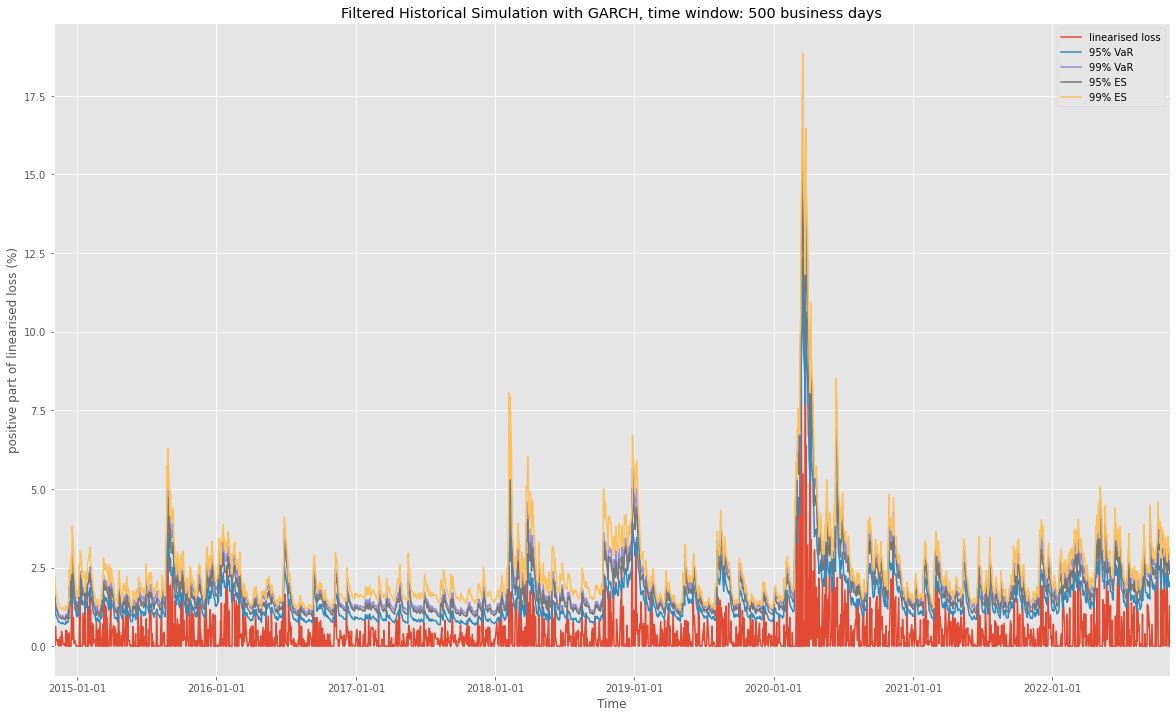

In [83]:
x=dog['Date'].iloc[501:].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in x]
df_to_plot = pd.DataFrame(data = np.array([y[500:], garch_var_95, garch_var_99, garch_es_95, garch_es_99]).T, 
                  index = index, 
                  columns = ["linearised loss", "95% VaR", "99% VaR", "95% ES", "99% ES"])

n=len(linloss_arr)
y=np.zeros(n)
for i in range(1,n):
  y[i]=linloss_arr[i] if linloss_arr[i]>0 else y[i]

ax = df_to_plot.plot(figsize=(20, 12))
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Filtered Historical Simulation with GARCH, time window: 500 business days")
plt.show()

Unconditional Coverage test

In [84]:
total_number_of_violations_95 = totalNumberOfViolations(linloss_arr, garch_var_95)
total_number_of_violations_99 = totalNumberOfViolations(linloss_arr, garch_var_99)

# T = 2018 because the last entry of Var_HS is discarded
pi_hat_95 = total_number_of_violations_95/(len(garch_var_95))
pi_hat_99 = total_number_of_violations_99/(len(garch_var_99))

print(total_number_of_violations_95)
print(total_number_of_violations_99)
print(pi_hat_95)
print(pi_hat_99)

109
31
0.05401387512388504
0.015361744301288404


In [85]:
T = 2018
LR_UC_95 = calculateUCLikelihoodRatio(0.95, pi_hat_95, T, total_number_of_violations_95)
LR_UC_99 = calculateUCLikelihoodRatio(0.99, pi_hat_99, T, total_number_of_violations_99)
print(LR_UC_95)
print(LR_UC_99)

0.6677860301907987
5.035007904970396


In [86]:
df = 1
pval_95 = 1 - chi2.cdf(LR_UC_95, df)
pval_99 = 1 - chi2.cdf(LR_UC_99, df)
print(pval_95)
print(pval_99)

0.4138245641401225
0.024839973424994888


Joint test

Level 95

In [87]:
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, garch_var_95)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1801 106 106 3
2016
0.05558468799160986
0.027522935779816515


In [88]:
LR_indep_95 = calculateIndepLikelihoodRatio(pi_hat_95, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_95 = LR_UC_95 + LR_indep_95
df = 2
pval_joint_95 = 1 - chi2.cdf(LR_joint_95, df)
print(LR_indep_95)
print(LR_joint_95)
print(pval_joint_95)

1.901072940863144
2.5688589710539427
0.2768084618255222


Level 99

In [89]:
(T00, T01, T10, T11) = calculateTransitionNumber(linloss_arr, garch_var_99)
print(T00, T01, T10, T11)
print(sum([T00, T01, T10, T11]))
pi_hat_01 = T01/(T00+T01)
pi_hat_11 = T11/(T01+T11)
print(pi_hat_01)
print(pi_hat_11)

1954 31 31 0
2016
0.015617128463476071
0.0


In [90]:
LR_indep_99 = calculateIndepLikelihoodRatio(pi_hat_99, pi_hat_01, pi_hat_11, (T00, T01, T10, T11))
LR_joint_99 = LR_UC_99 + LR_indep_99
df = 2
pval_joint_99 = 1 - chi2.cdf(LR_joint_99, df)
print(LR_indep_99)
print(LR_joint_99)
print(pval_joint_99)

0.9683322726748859
6.003340177645281
0.04970398893579653


Backtesting ES

In [91]:
xis_arr_95 = calculateXis(linloss_arr, garch_var_95, garch_es_95)
z_score_95 = sum(xis_arr_95) / math.sqrt(sum(np.square(xis_arr_95)))
pval_95 = 1 - norm.cdf(z_score_95)
print(z_score_95)
print(pval_95)

0.6362522920739727
0.262305997420891


In [92]:
xis_arr_99 = calculateXis(linloss_arr, garch_var_99, garch_es_99)
z_score_99 = sum(xis_arr_99) / math.sqrt(sum(np.square(xis_arr_99)))
pval_99 = 1 - norm.cdf(z_score_99)
print(z_score_99)
print(pval_99)

-1.203996806442319
0.8857045935562919


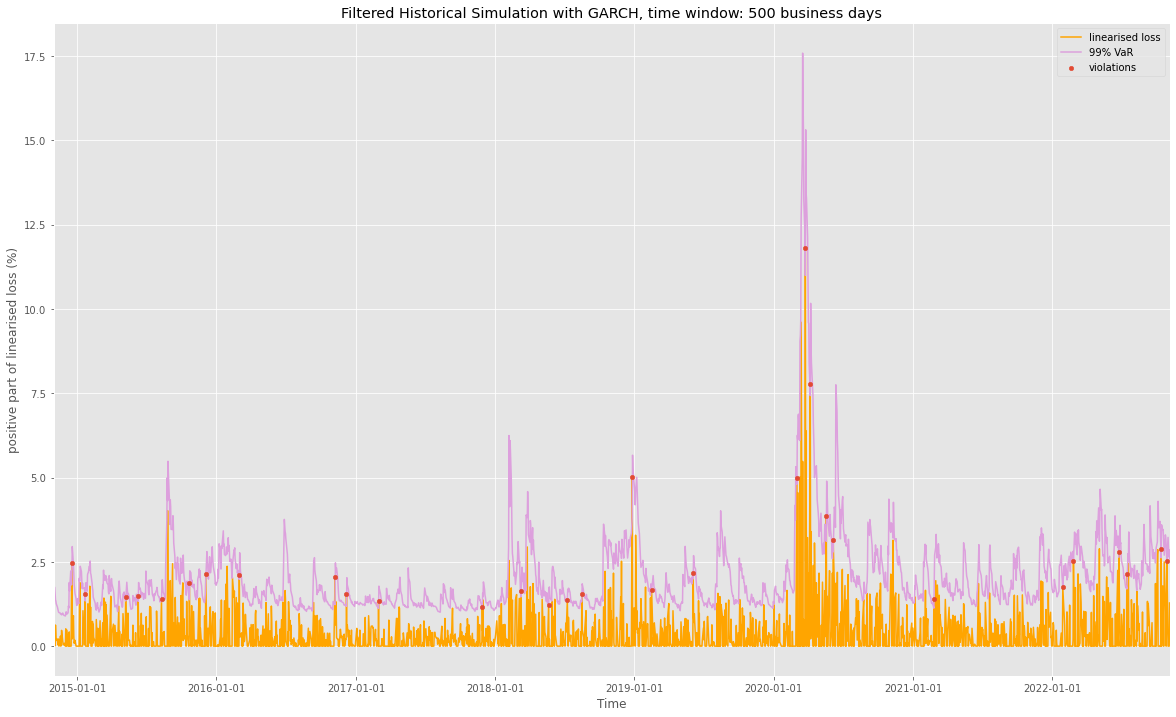

In [93]:
df_to_plot = pd.DataFrame(data = np.array([y[500:], garch_var_99]).T, 
                  index = index, 
                  columns = ["linearised loss", "99% VaR"])

ax = df_to_plot.plot(figsize=(20, 12), color={"linearised loss": "orange", "99% VaR": "plum"})
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# round to nearest years. Also, the index must be sorted and in a datetime format.
datemin = np.datetime64(df_to_plot.index[0])
datemax = np.datetime64(df_to_plot.index[-1])
ax.set_xlim(datemin, datemax)
ax.scatter(df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]].index,
            df_to_plot[df_to_plot["linearised loss"] >= df_to_plot["99% VaR"]]["linearised loss"], 
            s=20, zorder=10, label = "violations")
plt.xlabel("Time")
plt.ylabel("positive part of linearised loss (%)")
plt.title("Filtered Historical Simulation with GARCH, time window: 500 business days")
plt.legend()
plt.show()